In [1]:
!pip install torchtuples

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
import torchtuples as tt
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper 
%matplotlib inline 

In [3]:
!pip install pycox

In [4]:
# импортируем библиотеку pycox для построения нейронной сети DeepSurv
import pycox
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
X_full = pd.read_csv('data/METABRIC_RNA_Mutation.csv', low_memory=False)

In [7]:
clinical_df = X_full.iloc[:, :31]

In [8]:
clinical_df_inverted = clinical_df.copy()

In [9]:
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])

In [10]:
KM_df = clinical_df_inverted.copy()

In [11]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code', 'death_from_cancer'], axis=1, inplace=True)

In [12]:
cat_columns = [cname for cname in KM_df.columns if
                    KM_df[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype']


In [13]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [15]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(KM_df)
X_pandas

,cat__type_of_breast_surgery,cat__cancer_type_detailed,cat__cellularity,cat__pam50_+_claudin-low_subtype,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,...,remainder__neoplasm_histologic_grade,remainder__hormone_therapy,remainder__lymph_nodes_examined_positive,remainder__mutation_count,remainder__nottingham_prognostic_index,remainder__overall_survival_months,remainder__overall_survival,remainder__radio_therapy,remainder__tumor_size,remainder__tumor_stage
0,1.0,1.0,NaN,6.0,1.0,1.0,2.0,0.0,0.0,0.0,...,3.0,1,10.0,NaN,6.044,140.500000,0,1,22.0,2.0
1,0.0,1.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,...,3.0,1,0.0,2.0,4.020,84.633333,0,1,10.0,1.0
2,1.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,1.0,...,2.0,1,1.0,2.0,4.030,163.700000,1,0,15.0,2.0
3,1.0,4.0,2.0,3.0,1.0,1.0,2.0,0.0,4.0,1.0,...,2.0,1,3.0,1.0,4.050,164.933333,0,1,25.0,2.0
4,1.0,4.0,0.0,3.0,1.0,1.0,2.0,0.0,4.0,0.0,...,3.0,1,8.0,2.0,6.080,41.366667,1,1,40.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,0.0,2.0,0.0,2.0,1.0,1.0,2.0,0.0,1.0,1.0,...,3.0,1,1.0,4.0,5.050,196.866667,0,1,25.0,NaN
1900,1.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,...,3.0,0,1.0,6.0,5.040,44.733333,1,1,20.0,NaN
1901,1.0,1.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,3.0,1,45.0,4.0,6.050,175.966667,1,1,25.0,NaN
1902,1.0,1.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,...,2.0,1,12.0,15.0,5.050,86.233333,1,0,25.0,NaN


In [16]:
# немного непривычный способ после train/test sklearn, но не получалось нормально подать данные в модель, пришлось подглядеть и использовать
df_train = X_pandas
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [17]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [18]:
num_columns = [cname for cname in X_pandas.columns if 
                X_pandas[cname].dtype in ['int64', 'float64']]
print(num_columns)

['cat__type_of_breast_surgery', 'cat__cancer_type_detailed', 'cat__cellularity', 'cat__pam50_+_claudin-low_subtype', 'cat__er_status_measured_by_ihc', 'cat__er_status', 'cat__her2_status_measured_by_snp6', 'cat__her2_status', 'cat__tumor_other_histologic_subtype', 'cat__inferred_menopausal_state', 'cat__integrative_cluster', 'cat__primary_tumor_laterality', 'cat__pr_status', 'cat__3-gene_classifier_subtype', 'remainder__age_at_diagnosis', 'remainder__chemotherapy', 'remainder__neoplasm_histologic_grade', 'remainder__hormone_therapy', 'remainder__lymph_nodes_examined_positive', 'remainder__mutation_count', 'remainder__nottingham_prognostic_index', 'remainder__overall_survival_months', 'remainder__overall_survival', 'remainder__radio_therapy', 'remainder__tumor_size', 'remainder__tumor_stage']


In [19]:
cols_standardize = ['cat__cancer_type_detailed', 'cat__integrative_cluster', 'cat__primary_tumor_laterality', 'cat__pr_status', 'cat__3-gene_classifier_subtype', 'cat__cellularity', 'cat__her2_status_measured_by_snp6', 'cat__her2_status', 'cat__tumor_other_histologic_subtype','cat__pam50_+_claudin-low_subtype','remainder__age_at_diagnosis', 'remainder__neoplasm_histologic_grade', 'remainder__lymph_nodes_examined_positive', 'remainder__mutation_count', 'remainder__nottingham_prognostic_index', 'remainder__tumor_size', 'remainder__tumor_stage']
cols_leave = ['remainder__chemotherapy', 'remainder__hormone_therapy', 'remainder__overall_survival_months', 'remainder__overall_survival', 'remainder__radio_therapy']
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
x_mapper = DataFrameMapper(standardize + leave)
# ColumnTransformer не помог, пришлось выбрать x_mapper (как-то получалось все не так, точнее, не получалось)

In [20]:
df_train = X_pandas
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [21]:
# float32 - требование PyTorch
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [159]:
num_durations = 20

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda X_pandas: (X_pandas['remainder__overall_survival_months'].values, X_pandas['remainder__overall_survival'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)


months_test, events_test = get_target(df_test)

In [160]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [161]:
labtrans.cuts

array([  0.        ,  18.69473684,  37.38947368,  56.08421053,
        74.77894737,  93.47368421, 112.16842105, 130.86315789,
       149.55789474, 168.25263158, 186.94736842, 205.64210526,
       224.33684211, 243.03157895, 261.72631579, 280.42105263,
       299.11578947, 317.81052632, 336.50526316, 355.2       ])

In [162]:
labtrans.cuts[y_train[0]]

array([ 74.77894737, 168.25263158, 149.55789474, ..., 186.94736842,
       186.94736842,  93.47368421])

#Нейронная сеть 2 скрытых слоя по 32 каждый, ReLU активац ф-я, выходные переменные. Также потребуется batch normalization (пакетная нормализация) и dropout слои.

In [163]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [164]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [165]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [166]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 4.6847,	val_loss: 3.3286
1:	[0s / 0s],		train_loss: 3.4345,	val_loss: 2.9672
2:	[0s / 0s],		train_loss: 2.7011,	val_loss: 2.8647
3:	[0s / 0s],		train_loss: 2.1908,	val_loss: 2.4203
4:	[0s / 1s],		train_loss: 1.7865,	val_loss: 1.7875
5:	[0s / 1s],		train_loss: 1.4069,	val_loss: 1.2628
6:	[0s / 1s],		train_loss: 1.1223,	val_loss: 0.9822
7:	[0s / 1s],		train_loss: 0.9291,	val_loss: 0.9111
8:	[0s / 1s],		train_loss: 0.8190,	val_loss: 0.9980
9:	[0s / 2s],		train_loss: 0.7731,	val_loss: 0.7848
10:	[0s / 2s],		train_loss: 0.7039,	val_loss: 0.9342
11:	[0s / 3s],		train_loss: 0.6651,	val_loss: 0.8829
12:	[0s / 3s],		train_loss: 0.6747,	val_loss: 0.7349
13:	[0s / 3s],		train_loss: 0.6336,	val_loss: 0.7682
14:	[0s / 4s],		train_loss: 0.5952,	val_loss: 0.7257
15:	[0s / 4s],		train_loss: 0.5539,	val_loss: 0.6374
16:	[0s / 4s],		train_loss: 0.5527,	val_loss: 0.5387
17:	[0s / 5s],		train_loss: 0.6107,	val_loss: 0.5330
18:	[0s / 5s],		train_loss: 0.5317,	val_loss: 0.5201
19:

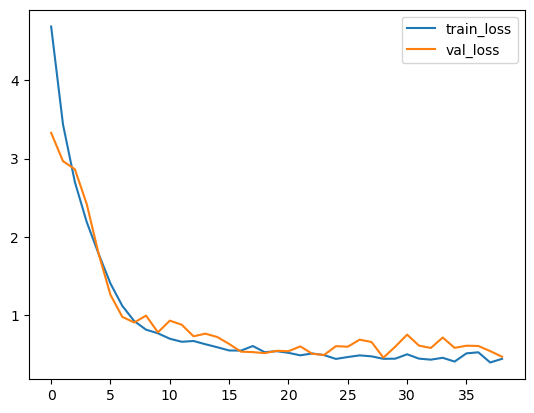

In [167]:
_ = log.plot()

In [168]:
log.to_pandas().val_loss.min()

0.4623577296733856

In [169]:
model.score_in_batches(val)

{'loss': 0.4623577296733856}

In [170]:
#предсказываем
surv = model.predict_surv_df(x_test)

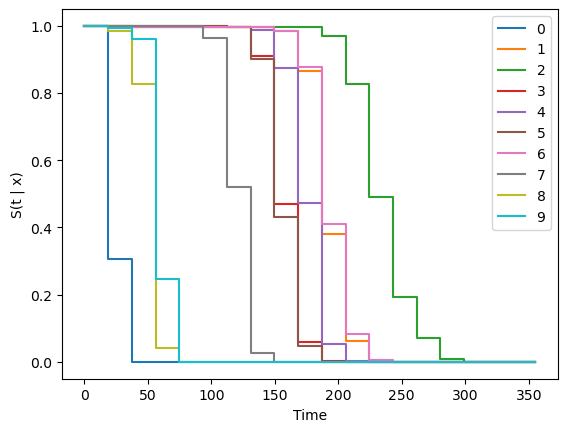

In [171]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [172]:
surv = model.interpolate(20).predict_surv_df(x_test)

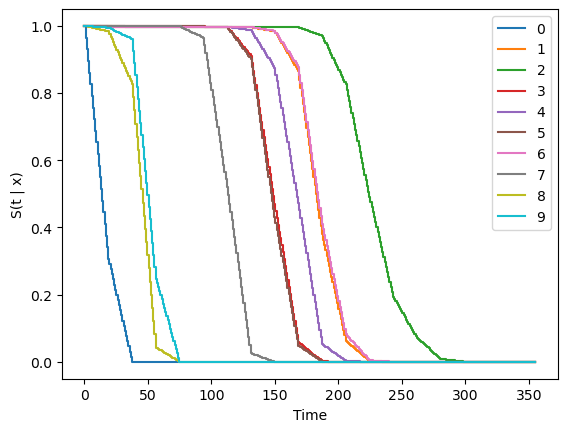

In [173]:
surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [174]:
ev = EvalSurv(surv, months_test, events_test, censor_surv='km')

In [175]:
ev.concordance_td('antolini') # получился неожиданно высокий результат

0.9953782383419689

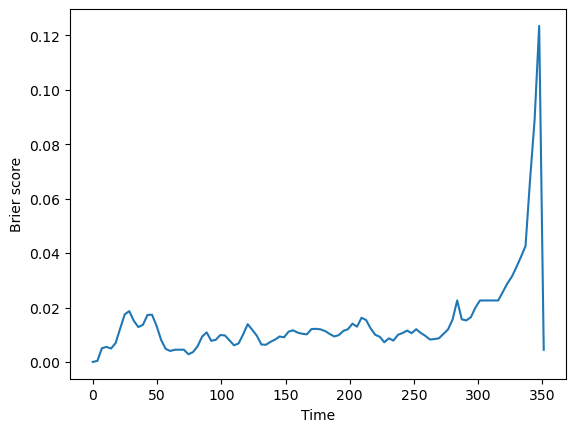

In [176]:
time_grid = np.linspace(months_test.min(), months_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

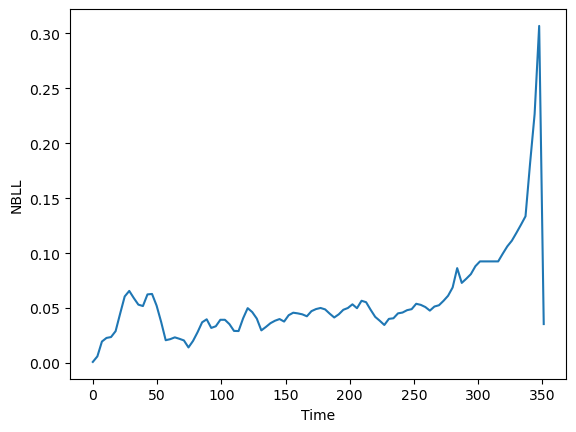

In [177]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [178]:
ev.integrated_brier_score(time_grid) 

0.014900479172242308

In [179]:
ev.integrated_nbll(time_grid) 

0.056971559059085394


gene_df = X_full.iloc[:, 23:520]
gene_df.drop(['radio_therapy', 'tumor_size', 'tumor_stage', 'pr_status', '3-gene_classifier_subtype', 'death_from_cancer'], axis= 1 , inplace= True )
gene_df.head(5)

gene_df = gene_df.fillna(gene_df.median())

df_train_gen = gene_df
df_test_gen = df_train_gen.sample(frac=0.2)
df_train_gen = df_train_gen.drop(df_test_gen.index)
df_val_gen = df_train_gen.sample(frac=0.2)
df_train_gen = df_train_gen.drop(df_val_gen.index)

cols_standardize_gen = []
cols_leave_gen = ['overall_survival', 'overall_survival_months']

standardize_gen = [([col], StandardScaler()) for col in cols_standardize_gen]
leave_gen = [(col, None) for col in cols_leave_gen]

x_mapper_gen = DataFrameMapper(standardize_gen + leave_gen)


x_train_gen = x_mapper_gen.fit_transform(df_train_gen).astype('float32')
x_val_gen = x_mapper_gen.fit_transform(df_val_gen).astype('float32')
x_test_gen = x_mapper_gen.fit_transform(df_test_gen).astype('float32')

num_durations = ?

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda gene_df: (gene_df['overall_survival_months'].values, gene_df['overall_survival'].values)
y_train_gen = labtrans.fit_transform(*get_target(df_train_gen))
y_val_gen = labtrans.transform(*get_target(df_val_gen))
train_gen = (x_train_gen, y_train_gen)
val_gen = (x_val_gen, y_val_gen)

durations_test, events_test = get_target(df_test_gen)

type(labtrans)

labtrans.cuts

in_features = x_train_gen.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 500
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train_gen, y_train_gen, batch_size, epochs, callbacks, val_data=val)